# `sklearn-mrmr` demo and comparison

In [19]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

sys.path.append(os.path.abspath('sklearn-mrmr'))
from mrmr import MRMRFeatureSelector


## IRT dataset

Availabe at https://archive.ics.uci.edu/dataset/942/rt-iot2022

In [25]:
irt = pd.read_csv('../data/ICI_groups1and2.csv')
irt = irt.drop(['SubjectID', 'aveOralM', 'Cosmetics', 'Date', 'Time'], axis=1)
irt = irt.dropna()
irt.head()

,T_offset1,Max1R13_1,Max1L13_1,aveAllR13_1,aveAllL13_1,T_RC1,T_RC_Dry1,T_RC_Wet1,T_RC_Max1,T_LC1,...,T_Max4,T_OR4,T_OR_Max4,aveOralF,Gender,Age,Ethnicity,T_atm,Humidity,Distance
0,-0.27,34.94,35.48,34.05,34.74,34.92,34.92,34.71,34.94,35.45,...,36.39,36.38,36.39,36.85,Male,41-50,White,24.0,28.0,0.8
1,-0.21,33.56,34.93,33.23,34.14,34.80,33.97,34.80,34.89,34.88,...,36.30,36.28,36.30,37.00,Female,31-40,Black or African-American,24.0,26.0,0.8
2,-0.28,35.91,35.60,35.46,34.71,35.83,35.83,35.50,35.91,35.58,...,36.63,36.59,36.63,37.20,Female,21-30,White,24.0,26.0,0.8
3,-0.32,35.25,35.46,33.78,33.88,35.24,35.20,35.22,35.25,35.60,...,35.88,35.55,35.57,36.85,Female,21-30,Black or African-American,24.0,27.0,0.8
4,-0.52,35.57,35.78,34.38,35.27,35.60,35.54,35.60,35.66,35.72,...,37.00,36.99,37.00,36.80,Male,18-20,White,24.0,27.0,0.8


In [26]:
y = irt['aveOralF']
X = irt.drop('aveOralF', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1804)

In [27]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=[object, 'category']).columns.tolist()

In [28]:
# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ]
)

basic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

param_grid_basic = {
    'regressor__n_estimators': [100, 200]
}

grid_search_basic = GridSearchCV(estimator=basic_pipeline, param_grid=param_grid_basic, cv=5, scoring='neg_mean_squared_error')

grid_search_basic.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Gender',
                                                                          'Age',
                                                                          'Ethnicity'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'regressor__n_estimators': [100, 200]},
             scoring='neg_mean_squared_error')

In [33]:
mrmr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', MRMRFeatureSelector(method='ftest')),
    ('regressor', RandomForestRegressor(random_state=42))
])

param_grid_mrmr = {
    'selector__n_features_to_select': [10, 20, 30, 40, 50, 70, 90, 110],
    'regressor__n_estimators': [100, 200]
}

grid_search_mrmr = GridSearchCV(estimator=mrmr_pipeline, param_grid=param_grid_mrmr, cv=5, scoring='neg_mean_squared_error')

grid_search_mrmr.fit(X_train, y_train)

/Users/benjaminhorvath/Dropbox/Projects/github/mrmr/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=20 is greater than n_features=16. All the features will be returned.
  warnings.warn(
/Users/benjaminhorvath/Dropbox/Projects/github/mrmr/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=20 is greater than n_features=16. All the features will be returned.
  warnings.warn(
/Users/benjaminhorvath/Dropbox/Projects/github/mrmr/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=20 is greater than n_features=16. All the features will be returned.
  warnings.warn(
/Users/benjaminhorvath/Dropbox/Projects/github/mrmr/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=20 is greater than n_features=16. All the features will be returned.
  warnings.warn(
/Users/benjaminhorvath/D

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Gender',
                                                                          'Age',
                                                                          'Ethnicity'])])),
                                       ('selector',
                                        MRMRFeatureSelector(method='ftest')),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'regressor__n_estimators': [100, 200],
                         'selector__n_features_to_select': [10, 20, 30, 40, 50,
                                                            70, 90, 110]},
             scoring='neg_mean_squared_error')

In [34]:
# Assemble CV
cv_basic = pd.DataFrame(grid_search_basic.cv_results_)
cv_basic['pipeline'] = 'basic'
cv_basic['param_selector__n_features_to_select'] = 127

cv_mrmr = pd.DataFrame(grid_search_mrmr.cv_results_)
cv_mrmr['pipeline'] = 'mrmr'

cv_mrmr.head(10)

cv = pd.concat([cv_basic, cv_mrmr])

cv.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,pipeline,param_selector__n_features_to_select
0,0.039986,0.002793,0.002017,0.000126,100,{'regressor__n_estimators': 100},-0.130957,-0.091577,-0.137105,-0.148184,-0.161476,-0.133860,0.023557,1,basic,127
1,0.075738,0.000498,0.003346,0.000069,200,{'regressor__n_estimators': 200},-0.130964,-0.091578,-0.138443,-0.148813,-0.160692,-0.134098,0.023496,2,basic,127
0,0.090393,0.004941,0.002064,0.000092,100,"{'regressor__n_estimators': 100, 'selector__n_...",-0.127004,-0.084585,-0.135726,-0.147834,-0.155815,-0.130193,0.024854,1,mrmr,10
1,0.095567,0.002964,0.002288,0.000150,100,"{'regressor__n_estimators': 100, 'selector__n_...",-0.130957,-0.091577,-0.137105,-0.148184,-0.161476,-0.133860,0.023557,3,mrmr,20
2,0.093088,0.003291,0.002225,0.000074,100,"{'regressor__n_estimators': 100, 'selector__n_...",-0.130957,-0.091577,-0.137105,-0.148184,-0.161476,-0.133860,0.023557,3,mrmr,30


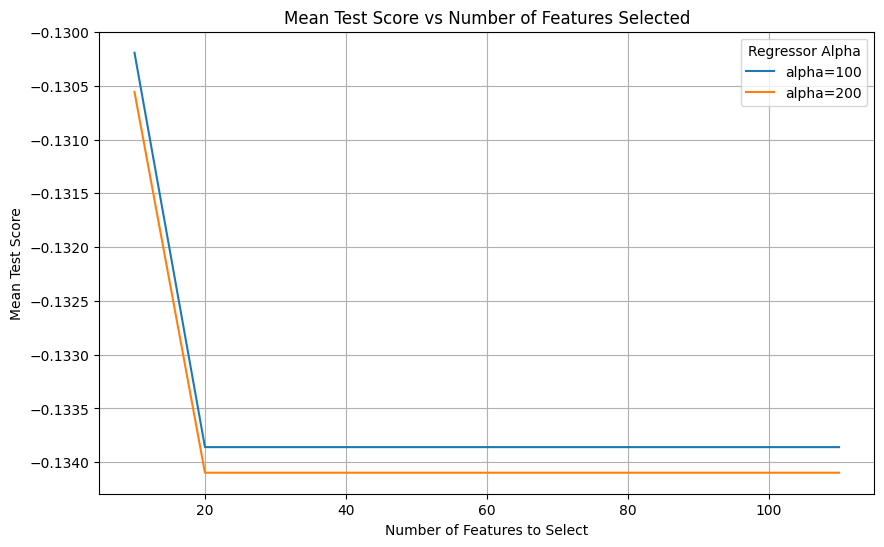

In [35]:
plt.figure(figsize=(10, 6))

# Plot each line for each unique value of param_regressor__alpha
for alpha in cv_mrmr['param_regressor__n_estimators'].unique():
    subset = cv_mrmr[cv_mrmr['param_regressor__n_estimators'] == alpha]
    plt.plot(subset['param_selector__n_features_to_select'], subset['mean_test_score'], label=f'alpha={alpha}')

# Add labels and legend
plt.xlabel('Number of Features to Select')
plt.ylabel('Mean Test Score')
plt.title('Mean Test Score vs Number of Features Selected')
plt.legend(title='Regressor Alpha')
plt.grid(True)
plt.show()

In [36]:
cv_basic

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,pipeline,param_selector__n_features_to_select
0,0.039986,0.002793,0.002017,0.000126,100,{'regressor__n_estimators': 100},-0.130957,-0.091577,-0.137105,-0.148184,-0.161476,-0.133860,0.023557,1,basic,127
1,0.075738,0.000498,0.003346,0.000069,200,{'regressor__n_estimators': 200},-0.130964,-0.091578,-0.138443,-0.148813,-0.160692,-0.134098,0.023496,2,basic,127


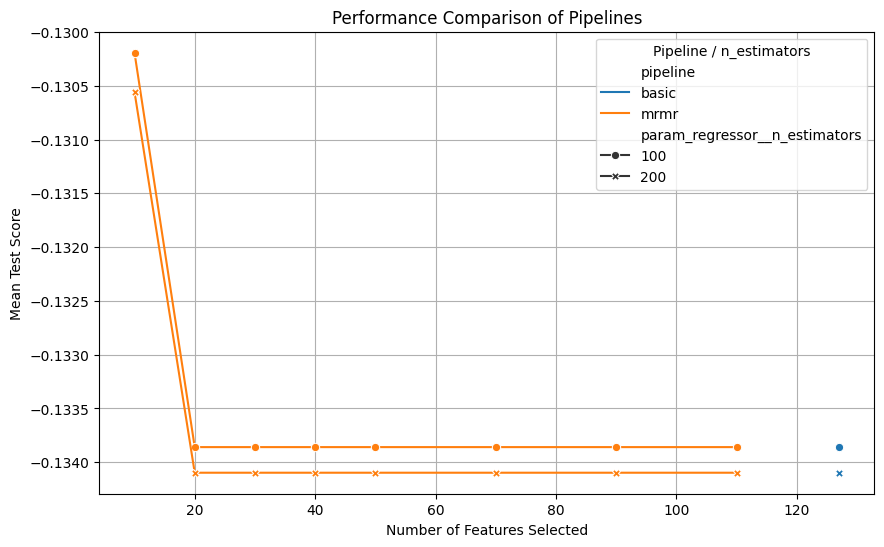

In [40]:
dff = cv[['pipeline', 'param_selector__n_features_to_select', 'param_regressor__n_estimators', 'mean_test_score']]

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=dff, x='param_selector__n_features_to_select', y='mean_test_score', hue='pipeline', style='param_regressor__n_estimators', markers=True, dashes=False)

# Set plot labels and title
plt.xlabel('Number of Features Selected')
plt.ylabel('Mean Test Score')
plt.title('Performance Comparison of Pipelines')
plt.legend(title='Pipeline / n_estimators')
plt.grid(True)

# Show the plot
plt.show()

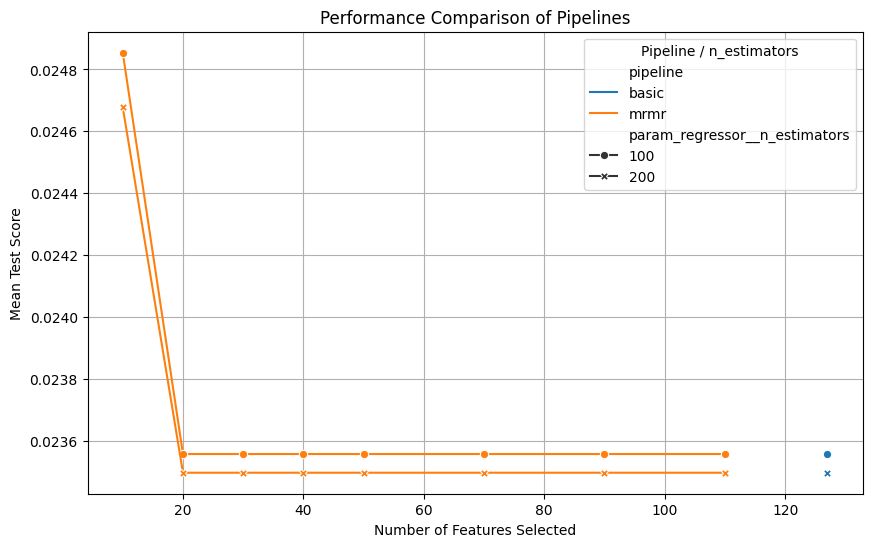

In [41]:
dff = cv[['pipeline', 'param_selector__n_features_to_select', 'param_regressor__n_estimators', 'std_test_score']]

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=dff, x='param_selector__n_features_to_select', y='std_test_score', hue='pipeline', style='param_regressor__n_estimators', markers=True, dashes=False)

# Set plot labels and title
plt.xlabel('Number of Features Selected')
plt.ylabel('Mean Test Score')
plt.title('Performance Comparison of Pipelines')
plt.legend(title='Pipeline / n_estimators')
plt.grid(True)

# Show the plot
plt.show()